<a href="https://colab.research.google.com/github/JoHyunjeong/Deep_learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%A4%EC%8A%B5/4_%EA%B0%9D%EC%B2%B4%20%ED%83%90%EC%A7%80%20%EB%B0%8F%20%EC%98%81%EC%83%81%20%EC%9D%B8%EC%8B%9D%20%EB%AA%A8%EB%8D%B8%EB%A7%81/Ch01_image_classficiation_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84_%EB%B0%8F_%EC%84%B1%EB%8A%A5_%EA%B0%9C%EC%84%A0%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제: CNN을 이용한 Image Classification 구현하고 성능 개선하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용합니다.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

    1. seg_train
      - training용 data
      
    2. seg_test
      - test/validation용 data
      - label 있음
      - 이번 실습에서는 validation data로 사용

    3. set_pred
      - test용 data
      - label 없음
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 하겠습니다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [ ]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
## Hyper-Parameter 설정(최적화된 값은 아님)
# image resolution
RES = 224
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어줍니다.
    

In [ ]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [ ]:
## data download 받기(gdown.download 사용)
##### CODE HERE #####
gdown.download(data_url, 'intel_image_classification.tar', quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ 



In [ ]:
# gdown.download가 안되서 구글링한 방법
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ

Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
100% 388M/388M [00:01<00:00, 226MB/s]


In [ ]:
# 압축 풀기
!tar -xf ./intel_image_classification.tar

    - 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정합니다

In [ ]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [ ]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만듭니다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정합니다.
    - training data는 shuffle=True로 설정합니다.

In [ ]:
##### CODE HERE #####
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES, RES), # (224,224)
    batch_size=N_BATCH # 64
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장합니다.

In [ ]:
##### CODE HERE #####
N_TRAIN = 14034
N_VAL = 3000

### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성합니다

In [ ]:
##### CODE HERE #####
# classes = ['buildings', 'forest', 'mountains', 'glacier', 'sea', 'street']

classes = train_ds.class_names # directory 이름을 class 이름으로 사용
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    - data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용합니다

In [ ]:
# 위에서 설정한 AUTOTUNE = tf.data.AUTOTUNE => tf가 알아서 적당한 값을 넣어서 prefetch를 해줌(원래는 데이터 개수를 넣어줘야 함)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

### 문제 5. dataset 확인하기
    - train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력합니다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣습니다.

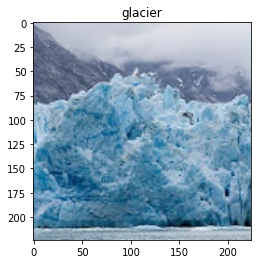

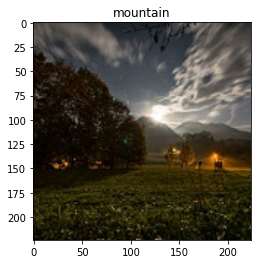

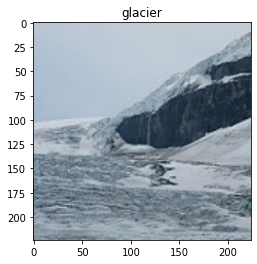

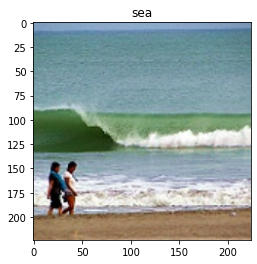

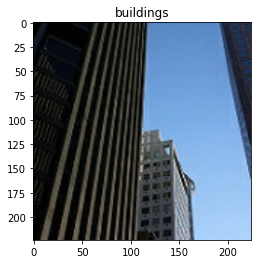

In [ ]:
##### CODE HERE #####
# for images, lables in train_ds.take(5): # .take(5) => 배치 5개(1배치는 64개)
#   plt.imshow(images[0]) # 첫번째 이미지 출력
#   plt.show()

# 위 코드를 그대로 실행하면, dataset만들 때 resize하면서 원래 픽셀값이 변형되었으므로 이미지가 제대로 출력되지 않음

for images, lables in train_ds.take(5): # .take(5) => 배치 5개(1배치는 64개)
  plt.imshow(images[0].numpy().astype('uint8')) # 첫번째 이미지 출력
  plt.title(classes[lables[0].numpy().astype('uint8')])
  plt.show()

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보겠습니다.

    - pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공합니다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받습니다.
  

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input # MobileNetV3를 학습할 때 사용된 data preprocessing 함수
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3)) # input_shape(224,224,3)
# include_top=False => 마지막 classifier의 fully connect layer를 불러오지 않음(원래 class 1000개짜리 적용 모델이었음)

In [ ]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

### 문제 6. Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어봅시다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용합니다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing될 수 있도록 합니다.

keras에서 제공하는 model 만들 수 있는 방법
1. Sequential API
2. functional API
3. model class를 상속

In [ ]:
##### CODE HERE #####
def create_model():
  inputs = keras.Input(shape=(RES, RES, 3))
  x = preprocess_input(inputs)
  x = mobilenetv3(x)
  x = GlobalAveragePooling2D()(x) # (7,7) -> (1,1)
  x = Dense(N_CLASS)(x)
  x = BatchNormalization()(x)
  outputs = Softmax()(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 6)                 3462      
                                                                 
 batch_normalization_3 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                           

  ### 문제 7. 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용합니다.
    - loss는 cross entropy를 사용합니다.

In [ ]:
##### CODE HERE #####
model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR), 
              loss=keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy']) # sparse_categorical_crossentropy => 정답이 원핫인코딩 안되어있는 경우 이 loss를 사용

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 74s 262ms/step - loss: 2.0703 - accuracy: 0.1908 - val_loss: 1.9820 - val_accuracy: 0.1510
Epoch 2/50
220/220 [==============================] - 56s 251ms/step - loss: 1.8688 - accuracy: 0.2602 - val_loss: 1.8327 - val_accuracy: 0.2107
Epoch 3/50
220/220 [==============================] - 56s 251ms/step - loss: 1.7135 - accuracy: 0.3239 - val_loss: 1.6859 - val_accuracy: 0.2883
Epoch 4/50
220/220 [==============================] - 56s 251ms/step - loss: 1.5947 - accuracy: 0.3756 - val_loss: 1.5674 - val_accuracy: 0.3560
Epoch 5/50
220/220 [==============================] - 56s 250ms/step - loss: 1.5032 - accuracy: 0.4223 - val_loss: 1.4744 - val_accuracy: 0.4190
Epoch 6/50
220/220 [==============================] - 56s 250ms/step - loss: 1.4238 - accuracy: 0.4652 - val_loss: 1.3982 - val_accuracy: 0.4643
Epoch 7/50
220/220 [==============================] - 56s 251ms/step - loss: 1.3585 - accuracy: 0.4981 - val_loss: 1.3338 - val_ac

### 문제 8. Optimizer 변경하기
    - 같은 model에서 optimizer만 Adam으로 변경하여 학습해봅시다.

In [ ]:
##### CODE HERE #####
model = create_model()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
              loss=keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 39s 117ms/step - loss: 0.7755 - accuracy: 0.8013 - val_loss: 0.8114 - val_accuracy: 0.7820
Epoch 2/50
220/220 [==============================] - 24s 108ms/step - loss: 0.5148 - accuracy: 0.9126 - val_loss: 0.7345 - val_accuracy: 0.8210
Epoch 3/50
220/220 [==============================] - 24s 108ms/step - loss: 0.4542 - accuracy: 0.9312 - val_loss: 0.6727 - val_accuracy: 0.8507
Epoch 4/50
220/220 [==============================] - 24s 108ms/step - loss: 0.4131 - accuracy: 0.9419 - val_loss: 0.6250 - val_accuracy: 0.8723
Epoch 5/50
220/220 [==============================] - 24s 108ms/step - loss: 0.3830 - accuracy: 0.9498 - val_loss: 0.5857 - val_accuracy: 0.8893
Epoch 6/50
220/220 [==============================] - 24s 108ms/step - loss: 0.3521 - accuracy: 0.9615 - val_loss: 0.5396 - val_accuracy: 0.9110
Epoch 7/50
220/220 [==============================] - 24s 108ms/step - loss: 0.3221 - accuracy: 0.9678 - val_loss: 0.5700 - val_ac

SGD보다 Adam이 성능이 더 좋게 나옴  
하지만 SGD에 Momentum 값을 설정하여 학습하면 비슷하게 나올 수 있음

## Step3. Model 성능 올리기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하겠습니다.

### 문제 9. Data augmentation 사용하기
    - training data에 data augmentation을 적용해봅시다.
    - dataset을 만들 때 training data를 256x256으로 resize합니다.
    - augmentation function을 만들고, 224x224로 random crop합니다.
    - horizontal flip(좌우반전)도 random으로 적용합니다.
    - augmentation을 하였으므로 training epoch을 100으로 키웁니다.
      (데이터가 늘어났으니, epoch을 키워줌)
    - optimizer와 다른 hyperparameter는 수정하지 않고 training합니다.

In [ ]:
##### CODE HERE #####
RES_BEF = 256
N_EPOCH = 100

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF), # (256,256)
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.


In [ ]:
def aug(image, label):
  image = tf.image.random_crop(image, [RES, RES, 3]) # (224, 224, 3)
  image = tf.image.random_flip_left_right(image) # horizontal flip
  return image, label

In [ ]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
# 배치 단위로 같은 뿐이 crop되는 것을 방지하기 위해 배치를 풀고 함수를 적용(하나씩 적용)한 후 다시 배치를 적용함
# data는 14034개, 배치는 64개 => 딱 떨어지지 않음. drop_remainder=True => 64개로 나누고 남은 데이터는 사용하지 않음(shuffle로 데이터를 사용하므로 아예 안쓰이는 것이 아님!)

In [ ]:
model = create_model()

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=LR),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 27s 104ms/step - loss: 0.4821 - accuracy: 0.9465 - val_loss: 0.3461 - val_accuracy: 0.9273
Epoch 2/100
219/219 [==============================] - 22s 99ms/step - loss: 0.3654 - accuracy: 0.9746 - val_loss: 0.3764 - val_accuracy: 0.9333
Epoch 3/100
219/219 [==============================] - 22s 99ms/step - loss: 0.3361 - accuracy: 0.9799 - val_loss: 0.3874 - val_accuracy: 0.9287
Epoch 4/100
219/219 [==============================] - 22s 99ms/step - loss: 0.3204 - accuracy: 0.9824 - val_loss: 0.3956 - val_accuracy: 0.9300
Epoch 5/100
219/219 [==============================] - 22s 99ms/step - loss: 0.3018 - accuracy: 0.9841 - val_loss: 0.4031 - val_accuracy: 0.9270
Epoch 6/100
219/219 [==============================] - 22s 99ms/step - loss: 0.2859 - accuracy: 0.9868 - val_loss: 0.4018 - val_accuracy: 0.9277
Epoch 7/100
219/219 [==============================] - 22s 99ms/step - loss: 0.2704 - accuracy: 0.9903 - val_loss: 0.4023 - val_a

### 문제 10. cutmix 알고리즘 구현을 위한 dataset 재생성
    - data augmentation 방법 중 하나인 cutmix를 구현해봅시다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인할 수 있습니다.
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋습니다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 합니다.

In [ ]:
##### CODE HERE #####
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical', # label_model='categorical' => label을 onehot으로 줌
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


    - 아래 코드를 실행하여 제대로 one-hot encoding이 되어있는지 확인해봅시다

In [ ]:
for images, labels in train_ds.take(1):  
  print(labels[0].numpy())
for images, labels in val_ds.take(1):  
  print(labels[0].numpy())

[0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]


### 문제 11. cutmix 알고리즘 구현
    - cutmix 알고리즘을 구현해봅시다.
    - cutmix라는 함수를 만들어서 구현합니다.
    - 위에서 생성한 dataset에 map으로 적용할 수 있도록 images, labels를 입력으로 받습니다.

In [ ]:
##### CODE HERE #####
def cutmix(images, labels): # 배치 단위로 입력을 받음
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) # 0.5 이상이면 적용
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32) # 0~63 사이 숫자 중 하나를 뽑음(잘라낸 부분 채울 이미지 뽑기)

    W = RES
    H = RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32) # 잘라내는 부분 센터점 좌표 / 너무 구석에서 사진을 잘라오지 않도록 가장자리 제외
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W) # 잘라내는 부분 왼쪽 위 모서리 x좌표 / 값이 0보다 작아지면 0, W보다 커지면 W
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H) # 잘라내는 부분 왼쪽 위 모서리 y좌표
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W) # 잘라내는 부분 오른쪽 아래 모서리 x좌표
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H) # 잘라내는 부분 오른쪽 아래 모서리 y좌표

    mid_left = images[i, ymin:ymax, :xmin, :] # (Batch, Height, Width, Channel)
    mid_mid = images[i, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) # Batch는 인덱싱해서 사라지고 3차원이 됨(Height, Width, Channel) / x축 방향으로 이어 붙이기 위해 axis=1 적용
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0) # y축 방향으로 붙이기
    imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod * cut_h_mod) / (W * H), tf.float32)
    label1 = labels[i]
    label2 = labels[idx]
    new_label = ((1-alpha) * label1 + alpha * label2)
    labs.append(new_label)
    
  new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3]) # shape을 바꿔서 stack
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

### 문제 12. cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해봅니다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용합니다.

In [ ]:
##### CODE HERE #####
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

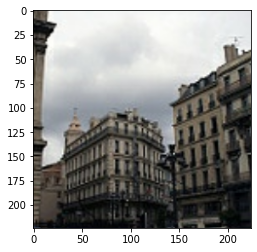

[1. 0. 0. 0. 0. 0.]


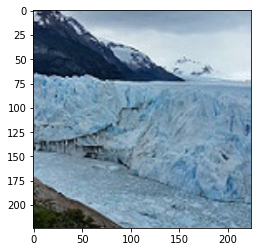

[1. 0. 0. 0. 0. 0.]


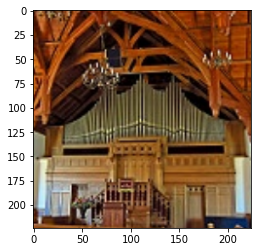

[1. 0. 0. 0. 0. 0.]


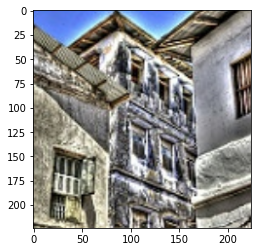

[1. 0. 0. 0. 0. 0.]


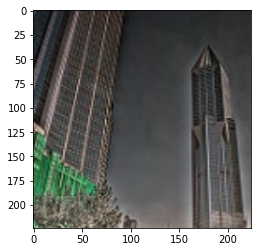

[1. 0. 0. 0. 0. 0.]


In [ ]:
##### CODE HERE #####
for images, lables in train_ds.take(5): 
  plt.imshow(images[0].numpy().astype('uint8'))
  plt.show()
  print(labels[0].numpy())

### 문제 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해봅시다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해봅시다.

In [ ]:
#### CODE HERE ####
model = create_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(LR),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 33s 125ms/step - loss: 1.1016 - accuracy: 0.6960 - val_loss: 0.7956 - val_accuracy: 0.7730
Epoch 2/100
219/219 [==============================] - 27s 120ms/step - loss: 0.9075 - accuracy: 0.7979 - val_loss: 0.7153 - val_accuracy: 0.8293
Epoch 3/100
219/219 [==============================] - 27s 120ms/step - loss: 0.8672 - accuracy: 0.8142 - val_loss: 0.6561 - val_accuracy: 0.8580
Epoch 4/100
219/219 [==============================] - 28s 124ms/step - loss: 0.8571 - accuracy: 0.8176 - val_loss: 0.6026 - val_accuracy: 0.8763
Epoch 5/100
219/219 [==============================] - 27s 119ms/step - loss: 0.8462 - accuracy: 0.8180 - val_loss: 0.5682 - val_accuracy: 0.8990
Epoch 6/100
219/219 [==============================] - 27s 121ms/step - loss: 0.8351 - accuracy: 0.8214 - val_loss: 0.5638 - val_accuracy: 0.8917
Epoch 7/100
219/219 [==============================] - 27s 120ms/step - loss: 0.8161 - accuracy: 0.8294 - val_loss: 0.5448 -

### 문제 14. Bigger resolution
    - input image resolution을 320x320으로 키워봅시다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정합니다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용합니다.

  

In [ ]:
##### CODE HERE #####

## Hyper-Parameter 설정
# image resolution
RES_BEF = 330
RES = 320
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 100
# learning rate
LR = 0.0001

In [ ]:
##### CODE HERE #####
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

### 문제 15. Learning rate warmup + cosine decay 구현하기
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해봅시다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 합니다. 
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미합니다.
      (batch 한 번 들어가는게 1 step)
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만듭니다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [ ]:
##### CODE HERE #####
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, max_lr, warmup_steps, decay_steps):
    super(CustomSchedule, self).__init__()
    self.max_lr = max_lr
    self.warmup_steps = warmup_steps
    self.decay_steps = decay_steps

  def __call__(self, step):
    lr = tf.cond(step < self.warmup_steps, # if문 대신 tf.cond 사용
                 lambda: self.max_lr / self.warmup_steps * step, # self.max_lr / self.warmup_steps : 기울기
                 lambda: 0.5 * (1+tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps)) * self.max_lr) # cosine그래프를 y축에서 1을 올리고 0.5를 곱해서 최대값을 1로
                                                                                                         # (step - self.warmup_steps) => x축이 warmup_steps만큼 이동했으므로 빼줌
    return lr

### 문제 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해봅시다.

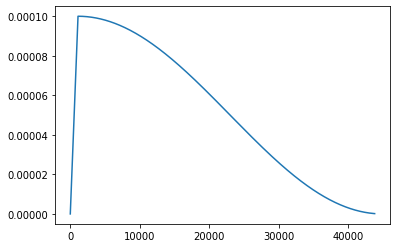

In [ ]:
##### CODE HERE #####
steps_per_epoch = N_TRAIN // N_BATCH
lr_schedule = CustomSchedule(LR, 5*steps_per_epoch, 200*steps_per_epoch)
lr = []
for step in range(steps_per_epoch*200):
  lr.append(lr_schedule(step))
step_list = list(np.arange(steps_per_epoch*200)+1) # x축
plt.plot(step_list, lr)
plt.show()

### 문제 17. Label smoothing 적용하여 학습하기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해봅시다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정합니다.
    - label smoothing 값은 0.1로 설정합니다.

In [ ]:
##### CODE HERE #####
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3)) # Resolution을 키웠기 때문에 다시 다운로드

In [ ]:
model = create_model()

In [ ]:
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, N_EPOCH*steps_per_epoch)
model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 55s 223ms/step - loss: 1.7156 - accuracy: 0.3739 - val_loss: 1.4573 - val_accuracy: 0.4707
Epoch 2/100
219/219 [==============================] - 48s 217ms/step - loss: 1.2023 - accuracy: 0.7191 - val_loss: 1.0282 - val_accuracy: 0.7600
Epoch 3/100
219/219 [==============================] - 48s 217ms/step - loss: 1.0880 - accuracy: 0.7912 - val_loss: 0.8869 - val_accuracy: 0.8353
Epoch 4/100
219/219 [==============================] - 48s 216ms/step - loss: 1.0455 - accuracy: 0.8127 - val_loss: 0.8347 - val_accuracy: 0.8677
Epoch 5/100
219/219 [==============================] - 48s 216ms/step - loss: 1.0338 - accuracy: 0.8192 - val_loss: 0.8187 - val_accuracy: 0.8863
Epoch 6/100
219/219 [==============================] - 48s 218ms/step - loss: 1.0138 - accuracy: 0.8270 - val_loss: 0.8020 - val_accuracy: 0.8900
Epoch 7/100
219/219 [==============================] - 49s 220ms/step - loss: 1.0046 - accuracy: 0.8273 - val_loss: 0.7913 -

### 문제 18. Learning rate decay(계단식) 적용하여 학습하기
    - 계단식으로 learning rate decay를 적용해봅시다.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습해봅시다.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용합니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [ ]:
##### CODE HERE #####
model = create_model()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True) # 계단식

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/100
219/219 [==============================] - 54s 222ms/step - loss: 1.0162 - accuracy: 0.8375 - val_loss: 0.6121 - val_accuracy: 0.9387
Epoch 2/100
219/219 [==============================] - 49s 220ms/step - loss: 0.9338 - accuracy: 0.8740 - val_loss: 0.6208 - val_accuracy: 0.9390
Epoch 3/100
219/219 [==============================] - 48s 218ms/step - loss: 0.9294 - accuracy: 0.8786 - val_loss: 0.6815 - val_accuracy: 0.9200
Epoch 4/100
219/219 [==============================] - 48s 219ms/step - loss: 0.9287 - accuracy: 0.8751 - val_loss: 0.6613 - val_accuracy: 0.9247
Epoch 5/100
219/219 [==============================] - 49s 220ms/step - loss: 0.9230 - accuracy: 0.8753 - val_loss: 0.6398 - val_accuracy: 0.9353
Epoch 6/100
219/219 [==============================] - 49s 222ms/step - loss: 0.9224 - accuracy: 0.8756 - val_loss: 0.6437 - val_accuracy: 0.9343
Epoch 7/100
219/219 [==============================] - 49s 220ms/step - loss: 0.9174 - accuracy: 0.8791 - val_loss: 0.6305 -